# Bayesian $\nu_\tau$ flux analysis with PyMC3

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az

from stat_analysis import *
import plotting

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

In [3]:
mc_df = pd.read_hdf('nominal_new_sim_09_29_2021.h5', 'df')

### Build signal and background templates

In [4]:
ASTRO_PHI = 2.12
ASTRO_GAMMA = 2.87

n_bins_net1 = 4
n_bins_net3 = 4

sig_NET1 = 0.99
sig_NET2 = 0.98
sig_NET3 = 0.85

livetime = 305684668.46

net3_val = 0.95
qasym_val = 0.05
outer_nums = np.array([75, 76, 77, 78, 72, 73, 74, 67, 59, 50, 40, 30, 21, 
                       13, 6, 5, 4, 3, 2, 1, 7, 14, 22, 31, 41, 51, 60, 68])
inner_or_qasym = lambda x: (~x.stnum0.isin(outer_nums)) | ((x.n3 > net3_val) & (x.q_asym > qasym_val))

### Priors for systematic effects

In [5]:
# flux priors
astro_norm_mean = 1.0
astro_norm_width = 0.3
conv_norm_mean = 1.0
conv_norm_width = 0.3
prompt_norm_mean = 1.0
prompt_norm_width = 0.3
mg_norm_mean = 2.0
mg_norm_width = 1.0

# detector effects are: DOM eff, scattering
syst_slopes = (0.6, 1) 
syst_widths = (0.1, 0.05) 
prior_types = ('uniform', 'norm')

### Apply signal cuts to the MC dataframe

In [6]:
exp_df = pd.DataFrame(mc_df[(mc_df.n1 > sig_NET1) & (mc_df.n2 > sig_NET2) & (mc_df.n3 > sig_NET3)])
exp_df = exp_df[inner_or_qasym].copy()

In [7]:
net1_bins = np.linspace(sig_NET1, 1.0, n_bins_net1 + 1)
net3_bins = np.linspace(sig_NET3, 1.0, n_bins_net3 + 1)

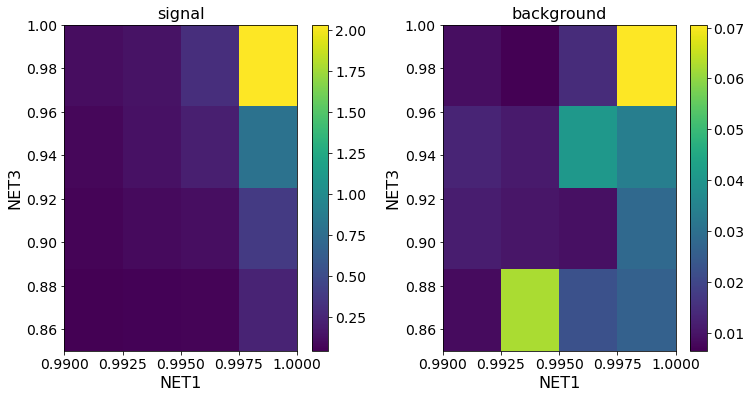

In [8]:
ana = Analysis(exp_df, livetime, net1_bins, net3_bins,
               astro_phi=ASTRO_PHI, astro_gamma=ASTRO_GAMMA,
               conv_model='honda2006',
               prompt_model='H3a_SIBYLL23C_pr',
               syst_slopes=syst_slopes,
               syst_widths=syst_widths,
               prior_types=prior_types,
               astro_norm_mean=astro_norm_mean,
               astro_norm_width=astro_norm_width,
               conv_norm_mean=conv_norm_mean,
               conv_norm_width=conv_norm_width,
               prompt_norm_mean=prompt_norm_mean,
               prompt_norm_width=prompt_norm_width,
               mg_norm_mean=mg_norm_mean,
               mg_norm_width=mg_norm_width)
ana.plot_templates()

In [9]:
ana.sig_hist.sum()

4.83704663971826

In [10]:
ana.bg_hist.sum()

0.37656545104326755

### Build a representative experiment histogram with 5 observed events

In [11]:
sample_hist = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 2, 2]])

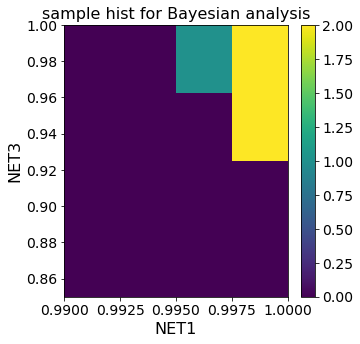

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
plotting.plot_hist(net1_bins, net3_bins, sample_hist, ax)
ax.set_title('sample hist for Bayesian analysis')
fig.savefig('bayesian_sample_hist.png', bbox_inches='tight')

### Fit a very simple model with no systematics

In [13]:
sig_hist = ana.sig_hist
bg_hist = ana.bg_hist

In [14]:
with pm.Model() as model:
    lambda_tau = pm.Uniform(r"$\lambda_\tau$", 0, 10)
    means = lambda_tau * sig_hist + bg_hist
    obs = pm.Poisson("counts", mu=means, observed=sample_hist)
    
    idata_no_syst = pm.sample(10000, tune=8000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\lambda_\tau$]


Sampling 4 chains for 8_000 tune and 10_000 draw iterations (32_000 + 40_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.7153869705248928, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'$\\lambda_\\tau$'}>,
        <AxesSubplot:title={'center':'$\\lambda_\\tau$'}>]], dtype=object)

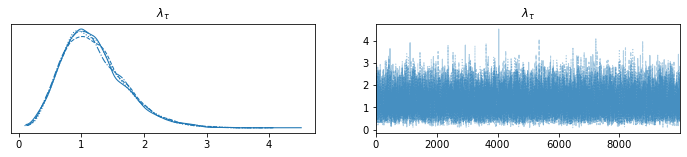

In [15]:
az.plot_trace(idata_no_syst)

<AxesSubplot:title={'center':'$\\lambda_\\tau$'}>

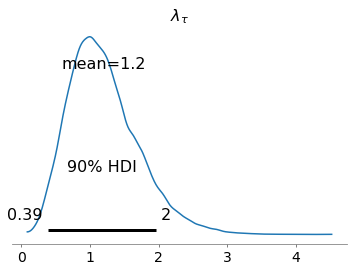

In [16]:
az.plot_posterior(idata_no_syst, hdi_prob=0.9)

### Fit a model including the systematic parameters

In [17]:
dom_eff_slope = syst_slopes[0]
dom_eff_width = syst_widths[0]
ice_slope = syst_slopes[1]
ice_width = syst_widths[1]

In [18]:
with pm.Model() as syst_model:
    lambda_tau = pm.Uniform(r"$\lambda_\tau$", 0, 10)
    sig_template = ana.group_hists[ana.group_names.index(r"astrophysical $\nu_\tau$ CC")]
    
    n_bg_components = len(ana.group_names)
    bg_comps = []
    for i_comp in range(1, n_bg_components):
        norm = ana.group_nominals[i_comp]
        width = ana.group_scales[i_comp]
        bg_comps.append(pm.TruncatedNormal(ana.group_names[i_comp], mu=norm, sigma=width, lower=0.0))
    
    bg_expectation = sum(flux * bg_hist for (flux, bg_hist) in zip(bg_comps, ana.group_hists[1:]))
    
    no_det_syst_sig = lambda_tau * sig_template
    no_det_syst_bg = bg_expectation
    
    dom_eff = pm.Uniform("DOM eff", -dom_eff_width, dom_eff_width)
    ice = pm.Normal("scattering", mu=0, sigma=ice_width)
    det_eps = dom_eff * dom_eff_slope + ice * ice_slope
    
    det_eps_scale = (1 + det_eps)
    
    signal_exp = pm.Deterministic("expected signal", det_eps_scale * no_det_syst_sig)
    bg_exp = pm.Deterministic("expected bg", det_eps_scale * no_det_syst_bg)
    
    nominal_exp = signal_exp + bg_exp
    
    bin_means = nominal_exp
    
    # include tauness in each bin
    tauness = pm.Deterministic(r"Tauness", (signal_exp / (signal_exp + bg_exp)).T[::-1, :])
    
    obs = pm.Poisson("counts", mu=bin_means, observed=sample_hist)
    
    idata_syst = pm.sample(10000, tune=8000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scattering, DOM eff, cosmic muon bg, prompt atmos bg, conventional atmos bg, astrophysical bg, $\lambda_\tau$]


Sampling 4 chains for 8_000 tune and 10_000 draw iterations (32_000 + 40_000 draws total) took 52 seconds.


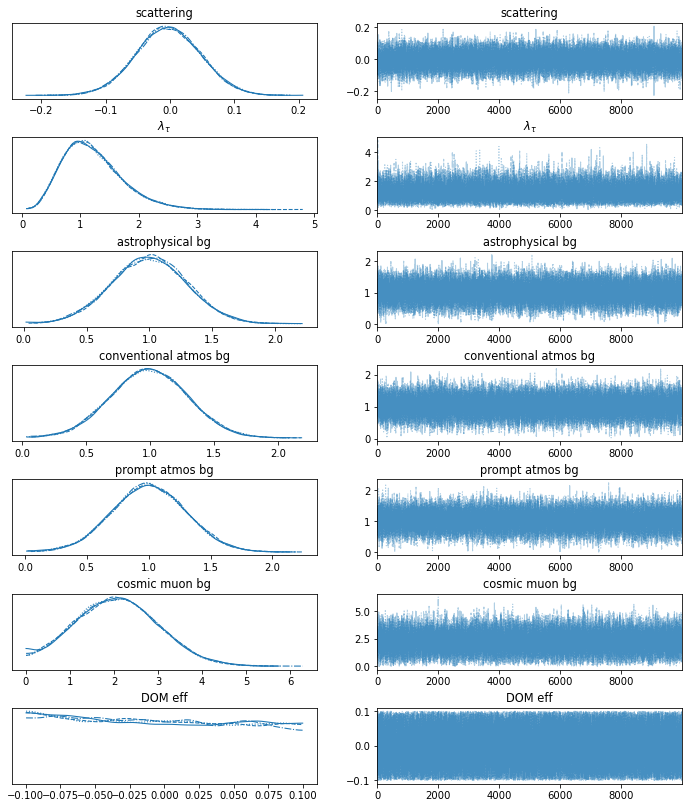

In [19]:
az.plot_trace(idata_syst, var_names=["~expected signal", "~expected bg", "~Tauness"])
plt.subplots_adjust(hspace=0.5)
plt.gcf().savefig('bayesian_traces.png', bbox_inches='tight')

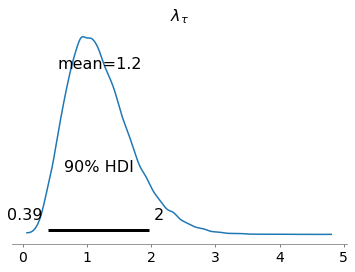

In [20]:
az.plot_posterior(idata_syst, [r"$\lambda_\tau$"], hdi_prob=0.9)
plt.savefig("bayesian_hdi.png", bbox_inches='tight')

<AxesSubplot:title={'center':'$\\lambda_\\tau$'}>

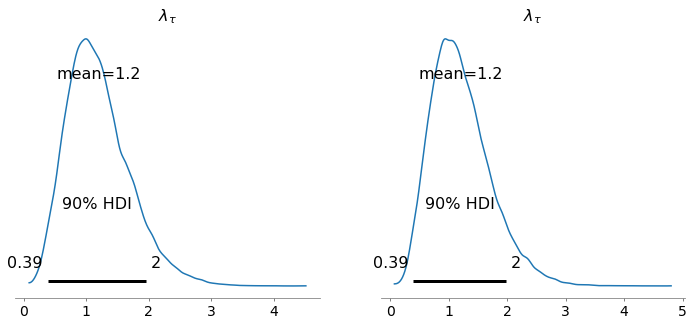

In [21]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
az.plot_posterior(idata_no_syst, [r"$\lambda_\tau$"], hdi_prob=0.9, ax=axes[0])
az.plot_posterior(idata_syst, [r"$\lambda_\tau$"], hdi_prob=0.9, ax=axes[1])

/home/atfienberg/packages/anac/anaconda3/envs/icetray/lib/python3.9/site-packages/arviz/utils.py:129: UserWarning: Items starting with ~: ['$\\tau$-ness'] have not been found and will be ignored
  warnings.warn(
/home/atfienberg/packages/anac/anaconda3/envs/icetray/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<AxesSubplot:ylabel='$\\lambda_\\tau$'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='astrophysical bg'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='conventional atmos bg'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='prompt atmos bg'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='cosmic muon bg'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='DOM eff'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot

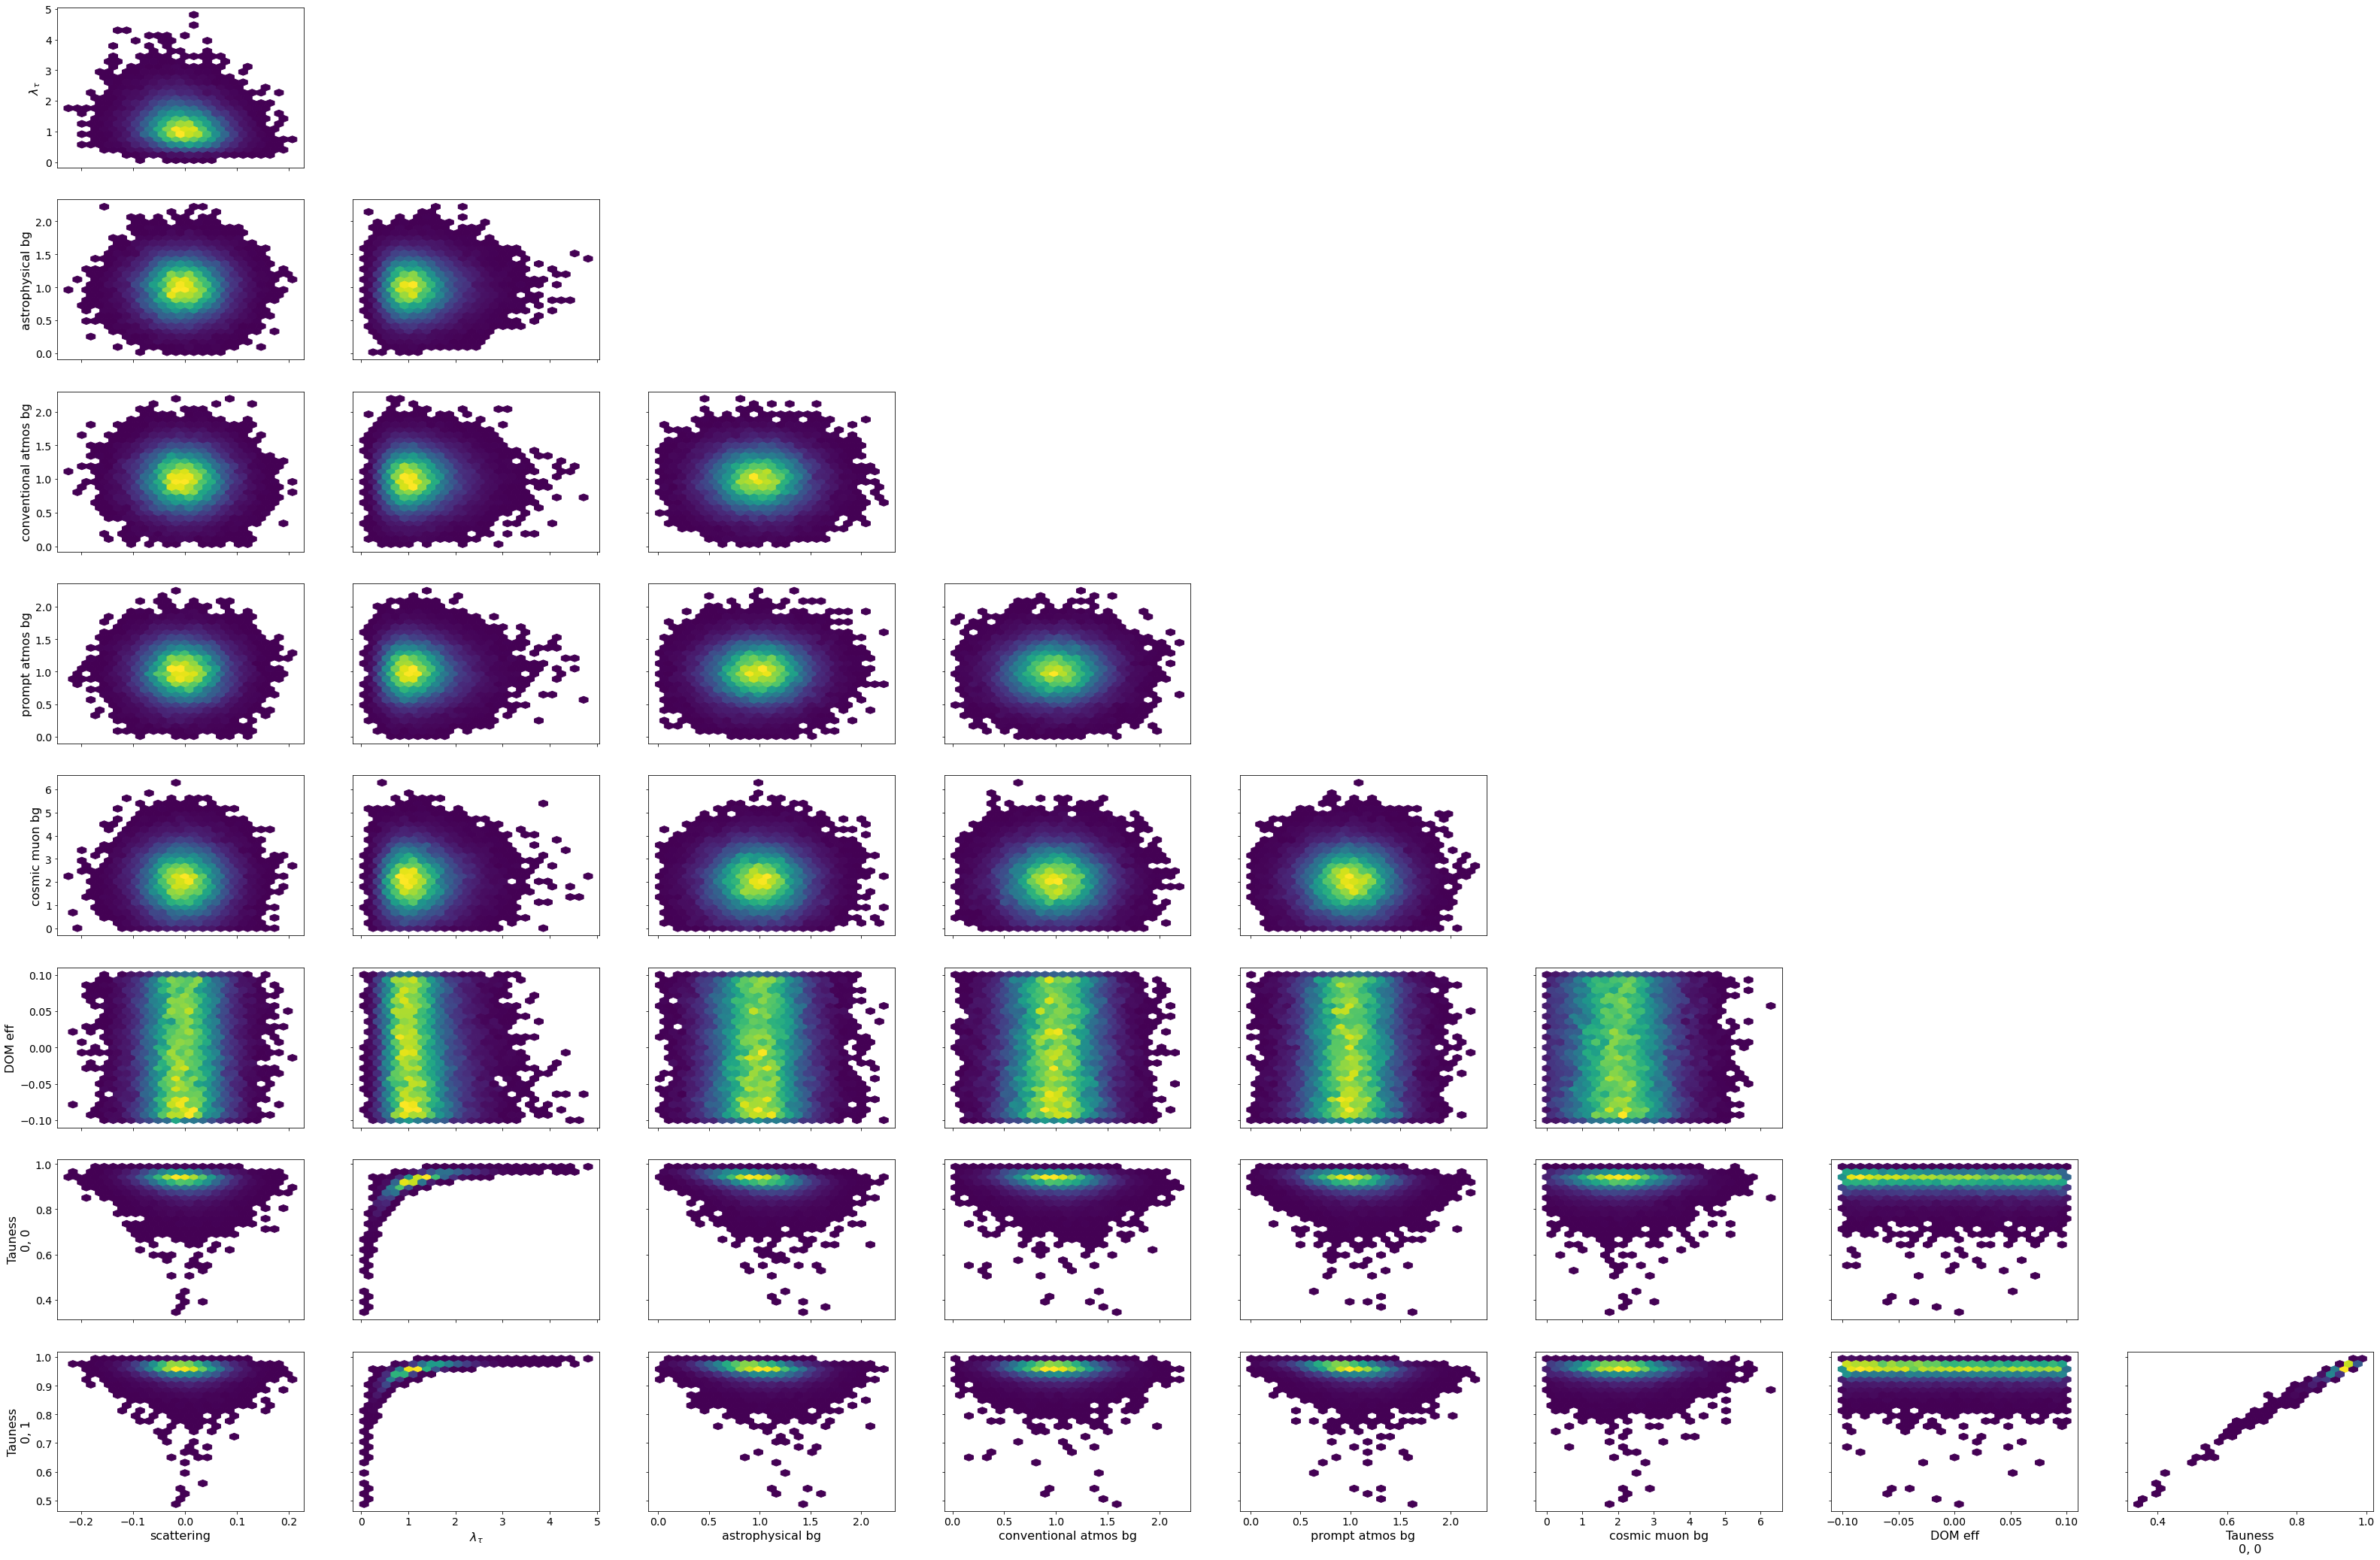

In [22]:
az.plot_pair(idata_syst, var_names=["~expected signal", "~expected bg", r"~$\tau$-ness"], kind='hexbin')

In [23]:
t = idata_syst.posterior

In [24]:
test = np.array(t[r"$\lambda_\tau$"][:, :])

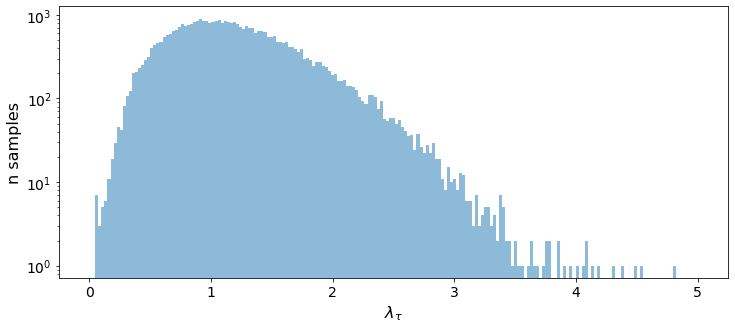

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
bins = np.linspace(0, 5, 200)
ax.hist(test.flatten(), bins=bins, histtype='stepfilled', alpha=0.5)
ax.set_xlabel(r'$\lambda_\tau$')
ax.set_ylabel('n samples')
ax.set_yscale('log')

# Tauness for each bin

array([[<AxesSubplot:title={'center':'Tauness\n0, 0'}>,
        <AxesSubplot:title={'center':'Tauness\n0, 1'}>,
        <AxesSubplot:title={'center':'Tauness\n0, 2'}>,
        <AxesSubplot:title={'center':'Tauness\n0, 3'}>],
       [<AxesSubplot:title={'center':'Tauness\n1, 0'}>,
        <AxesSubplot:title={'center':'Tauness\n1, 1'}>,
        <AxesSubplot:title={'center':'Tauness\n1, 2'}>,
        <AxesSubplot:title={'center':'Tauness\n1, 3'}>],
       [<AxesSubplot:title={'center':'Tauness\n2, 0'}>,
        <AxesSubplot:title={'center':'Tauness\n2, 1'}>,
        <AxesSubplot:title={'center':'Tauness\n2, 2'}>,
        <AxesSubplot:title={'center':'Tauness\n2, 3'}>],
       [<AxesSubplot:title={'center':'Tauness\n3, 0'}>,
        <AxesSubplot:title={'center':'Tauness\n3, 1'}>,
        <AxesSubplot:title={'center':'Tauness\n3, 2'}>,
        <AxesSubplot:title={'center':'Tauness\n3, 3'}>]], dtype=object)

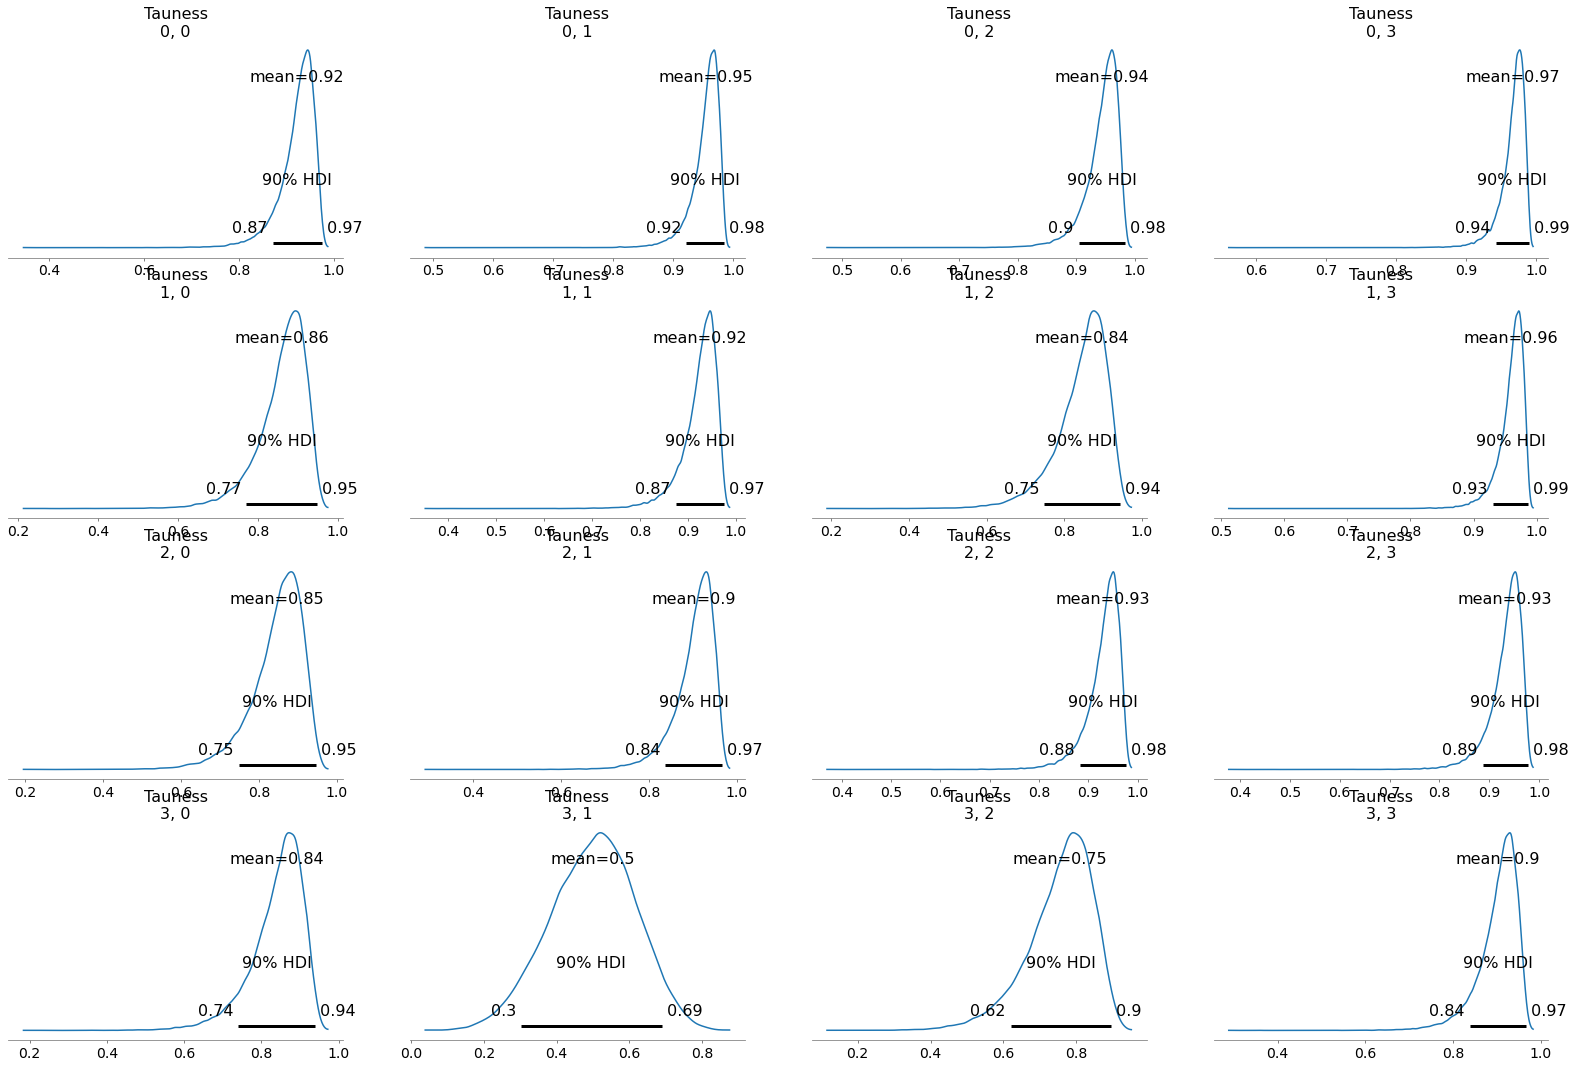

In [26]:
az.plot_posterior(idata_syst, [r"Tauness"], hdi_prob=0.9)

# Tauness for the top right bin

<AxesSubplot:title={'center':'Tauness\n0, 3'}>

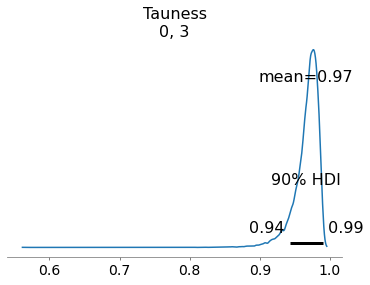

In [27]:
az.plot_posterior(idata_syst, [r"Tauness"], coords={"Tauness_dim_0": [0,], "Tauness_dim_1": [3,]}, hdi_prob=0.9)

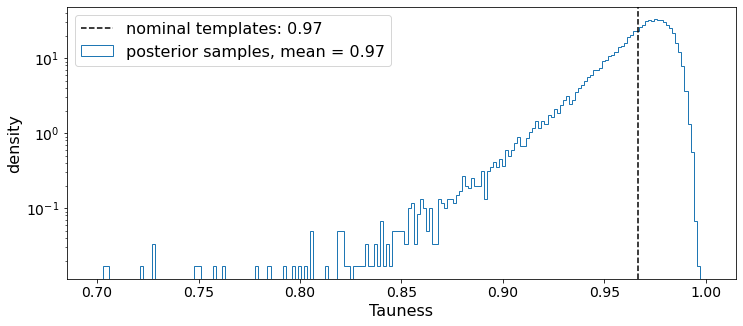

In [28]:
tauness_samples = np.array(idata_syst.posterior['Tauness'][..., 0, 3])
tauness_samples.shape = (tauness_samples.size,)
mean = np.average(tauness_samples)
nominal = ana.sig_hist[3, 3] / (ana.sig_hist[3, 3] + ana.bg_hist[3, 3])

fig, ax = plt.subplots(figsize=(12, 5))
bins = np.linspace(0.7, 1, 201)
a = ax.hist(tauness_samples, bins, histtype='step', density=True, label=f'posterior samples, mean = {mean:.2f}')
ax.set_yscale('log')
ax.set_xlabel('Tauness')
ax.set_ylabel('density')

# ax.set_title(f'mean = {:.2f}')
ax.axvline(nominal, color='black', linestyle='--', label=f'nominal templates: {nominal:.2f}')
ax.legend()
fig.savefig('tauness_example.png', bbox_inches='tight')